# Neural networks

*Tutors*:
-- Federico Milanesio: federico.milanesio@unito.it
-- Davide Pirovano: davide.pirovano@unito.it

<div>
<img src="https://imgs.xkcd.com/comics/trained_a_neural_net.png" width="300"/>
</div>

In this lesson, we will look at `nn` module of PyTorch, that contains the basic building blocks for Neural Networks.

In [1]:
import torch
from torch import nn                     # <-- this module contains all we need to train neural networks
from torch import optim
import matplotlib.pyplot as plt

# Importing the dataset

We will use a copy of [UCI ML Breast Cancer Wisconsin](https://goo.gl/U2Uwz2) (Diagnostic) datasets. The features are obtained from a digitized image of a fine needle aspirate (FNA) of a breast mass. These features are used to predict whether a detected breast mass is benign (non-cancerous) or malignant (cancerous).

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
X = data.data
y = data.target

In [4]:
X.shape

(569, 30)

# Data preprocessing

We can start with some basic preprocessing:

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split

In PyTorch, if we want to be able to use all the features offered by our modules, our data needs to be organized in a `Dataset` class. This is an abstract class representing a dataset, and it serves as an interface for custom datasets, allowing you to create your own dataset by subclassing it and implementing certain methods.

There are three functions that we need to start:

* `__init__`: This method initializes the dataset. You can pass any necessary parameters to initialize your dataset.

* `__len__`: This method returns the size of the dataset, i.e., the total number of samples in the dataset.

* `__getitem__`: This method is used to retrieve a sample from the dataset at a given index. It takes an index as input and returns the corresponding sample. It is called by PyTorch's data loaders during training or evaluation.

**SUPPLEMENTARY**: In Python, the double underscore (`__`) methods are special methods also known as "magic" or "dunder" methods. These methods provide functionality that can be customized to define how objects behave in certain situations. They are called "magic" methods because they are invoked implicitly in response to certain operations or built-in functions in Python.

For example, `__len__` returns the length of the object. It's called by the built-in `len()` function.


In [6]:
class CustomDataset(Dataset):

  def __init__(self, x, y):

    # this functions initializes our dataset

    self.x = torch.tensor(x, dtype = torch.float32)
    self.y = torch.tensor(y, dtype = torch.float32)

    self.length = self.x.shape[0]       # number of samples

  def __getitem__(self, idx):

    # given the index of an element, we return the element

    return self.x[idx], self.y[idx]

  def __len__(self):

    # this functions return the number of elements in our dataset

    return self.length

We initialize the dataset:

In [7]:
data = CustomDataset(X, y)

And we split it in test and train set:

In [8]:
n_test = int(0.2 * X.shape[0])  # we select 20% of data
n_test

113

In [9]:
# we split train and test set

train_set, test_set = random_split(data, [len(data) - n_test, n_test], generator=torch.Generator().manual_seed(42))

**Exercise 1**: preprocess your data. Compute the mean and std of each column of the training dataset and normalize both training and test set with:



$x_{ij} = \dfrac{x_{ij} - \bar x_j}{\sigma_j}$

In [10]:
train_set.dataset == data                       # inside train_set and test_set there is still the entire dataset

True

In [11]:
train_set.dataset.x[train_set.indices].size()    # this access the part of the dataset that is selected for train

torch.Size([456, 30])

In [12]:
# modify directly the "data" object

data = data # ...

# Batches

The primary purpose of DataLoader is to load data from a dataset. It takes an instance of a dataset as input and provides an iterable over the dataset. It  allows you to specify the `batch_size`, which determines the number of samples to be included in each batch, as well as to whether to `shuffle` the data at each epoch or not

In [13]:
BATCH_SIZE = 128

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size = len(test_set), shuffle=False)

# Creating a model

We start with the easiest way to create a neural network in PyTorch: `nn.Sequential` is a container module that allows you to sequentially compose layers or modules in a neural network. It provides a simple way to create complex neural network architectures by stacking multiple layers or modules one after the other. The layers/modules passed to `nn.Sequential` are executed in the order they are specified. The output of each layer serves as the input to the next layer.

In [14]:
input_dim = 30
hidden_dim = 100

model = nn.Sequential(
              nn.Linear(input_dim, hidden_dim),
              nn.ReLU(),
              nn.Linear(hidden_dim, 1),
              nn.Sigmoid())

Let's look inside the model:

In [15]:
print(model)

Sequential(
  (0): Linear(in_features=30, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
  (3): Sigmoid()
)


In [16]:
[param.shape for param in model.parameters()]

[torch.Size([100, 30]),
 torch.Size([100]),
 torch.Size([1, 100]),
 torch.Size([1])]

In [17]:
model[2].bias

Parameter containing:
tensor([0.0007], requires_grad=True)

We can use our model to predict by calling it like a functions. We pass input data through the network, and the forward method of `nn.Sequentia`l automatically executes the forward pass through each layer/module in the sequence, producing the final output.

In [18]:
sample = torch.tensor(X[:5], dtype = torch.float) # let's pass the first 15 samples to our new model

model(sample)

tensor([[0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [3.4591e-13],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)

# Training

Let's call $\hat y \in (0,1)$ the prediction of our network. We will need two metrics, accuracy:

$A_{cc} = \mathbb{E}[\mathbb{1}(round(\hat y) = y)]$

And (binary) cross entropy:

$C(y, \hat y) = \mathbb{E}[-y \log(\hat y)- (1- y) \log(1 -\hat y)]$

In [19]:
def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

  acc_train, acc_test = 0, 0

  with torch.no_grad():

    for x_train, y_train in train_loader:

      out = model(x_train).squeeze()
      acc_train += (out.round() == y_train).sum()

    for x_test, y_test in test_loader:

      out = model(x_test).squeeze()
      acc_test += (out.round() == y_test).sum()

    acc_train, acc_test = acc_train / len(train_loader.dataset), acc_test / len(test_loader.dataset)

  return acc_train.detach() * 100, acc_test.detach() * 100


In [20]:
EPOCHS = 5

train_losses = []
train_accuracies = []
test_accuracies = []


loss_function = nn.BCELoss()

learning_rate = 0.002
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(EPOCHS):

  train_loss = 0

  ## TRAIN STEP

  for x_train, y_train in train_loader:

    out = model(x_train)
    loss = loss_function(out.squeeze(), y_train)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    train_loss += loss

  train_loss /= len(train_loader)   # we divide by the number of batches

  ## TEST STEP

  train_acc, test_acc = evaluate(model, train_loader, test_loader)

  train_losses.append(train_loss.detach())
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)


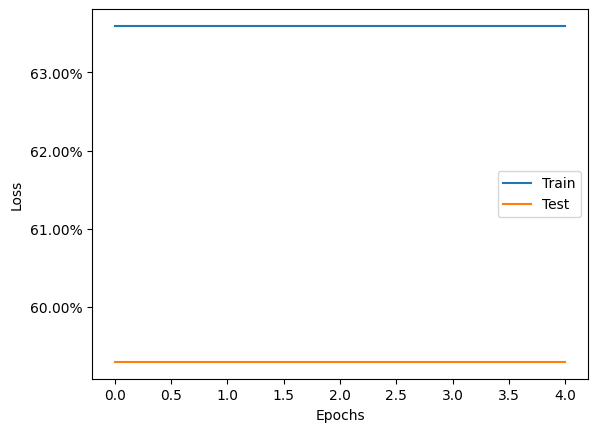

In [21]:
import matplotlib.ticker as mtick

plt.plot(train_accuracies, label = "Train")
plt.plot(test_accuracies, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.legend()

plt.show()

In [22]:
test_accuracies[-1]

tensor(59.2920)

**Exercise 2:** Can you get to 100% accuracy on the train set? What happens to test accuracy?

(*Hint: you can change lr, number of neurons, activations, etc.*)

**REMEMBER TO REINITIALIZE THE MODEL!**

# An exercise for you

Torchvision is a package in PyTorch for computer vision tasks. It provides easy access to pre-trained models, common datasets like ImageNet, CIFAR-10, and MNIST, as well as tools for image transformation and augmentation.

In [23]:
import torchvision


[MNIST](https://en.wikipedia.org/wiki/MNIST_database) stands for Modified National Institute of Standards and Technology database. It's a dataset commonly used in the field of machine learning and computer vision for training and testing algorithms. The MNIST dataset consists of a large collection of handwritten digits (0 through 9), which are stored as **grayscale images of size 28x28 pixels**.

The code below does many things: it downloads the MNIST dataset, it normalizes it and it splits it in train and test dataset. Then we will select only two numbers, 1 and 7, and we discard the rest. The ones will belong to class 1, while the 7s to class 0.

**DON'T PANIC**: we will get more into how `torchvision.dataset` works next time, if not all steps are clear, you just have to believe us that `train_loader` and `test_loader ` contain data that is ready to be passed to a Neural Network.

In [24]:
# Define batch sizes for training and testing data
batch_size_train = 128
batch_size_test = 10000

## IF THIS DOESN'T COMPILE CREATE A mnist DIRECTORY IN THE CURRENT DIRECTORY AND TRY AGAIN

# Load MNIST training dataset and apply transformations
train_dataset = torchvision.datasets.MNIST('./mnist/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),  # Convert image to PyTorch tensor
                               torchvision.transforms.Normalize(   # Normalize pixel values
                                 (0.1307,), (0.3081,))
                             ]))

# Load MNIST testing dataset and apply transformations
test_dataset = torchvision.datasets.MNIST('./mnist/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),  # Convert image to PyTorch tensor
                               torchvision.transforms.Normalize(   # Normalize pixel values
                                 (0.1307,), (0.3081,))
                             ]))

# Filter out images with labels 1 and 7 from the training dataset
indices = (train_dataset.targets == 1) + (train_dataset.targets == 7)
indices[8000:] = False  # Limit the number of images with labels 1 and 7
train_dataset.data, train_dataset.targets = train_dataset.data[indices], train_dataset.targets[indices]

# Convert labels to binary classification: 1 for label 1 and 0 for label 7
train_dataset.targets = torch.where(train_dataset.targets == 1, torch.tensor(1.), torch.tensor(0.))

# Same thing for the test dataset
indices = (test_dataset.targets == 1) + (test_dataset.targets == 7)
indices[4000:] = False
test_dataset.data, test_dataset.targets = test_dataset.data[indices], test_dataset.targets[indices]

test_dataset.targets = torch.where(test_dataset.targets == 1, torch.tensor(1.), torch.tensor(0.))

print("Train set composed of", len(train_dataset.targets), "samples and test set of", len(test_dataset.targets), "samples")

# Create data loaders for training and testing datasets
train_loader = torch.utils.data.DataLoader(train_dataset,
                              batch_size=batch_size_train, shuffle=True)  # Shuffle training data
test_loader = torch.utils.data.DataLoader(test_dataset,
                              batch_size=batch_size_test, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 118601372.83it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 84415117.65it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38217368.27it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10231218.46it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Train set composed of 1759 samples and test set of 861 samples


We extract some samples to see how they look.

In [25]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

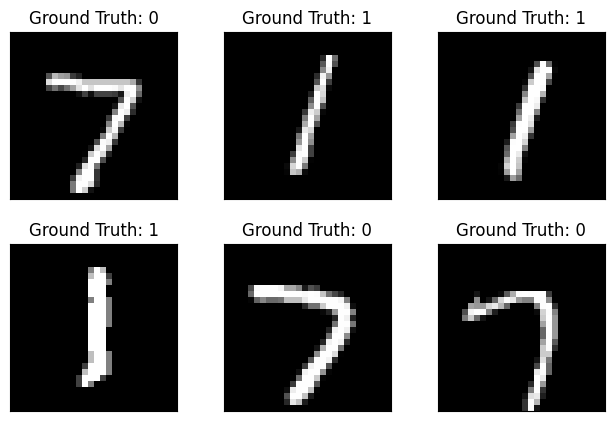

In [26]:
fig = plt.figure()

for i in range(6):

  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')           # used to show 2d images
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

In [27]:
input_dim = 28*28
hidden_dim = 10

model = nn.Sequential(
              nn.Flatten(1, 3),
              nn.Linear(input_dim, 1),
              )

This is the basic outline of our network. `nn.Flatten(1, 3)` is a layer in PyTorch that is used to flatten multidimensional input tensors into a 2D tensor.

In our example, we have an input tensor of shape `(batch_size, channels = 1, height = 28, width = 28)` and we apply `nn.Flatten(1, 3)` to it. The flattening operation will flatten the tensor along the channels and spatial dimensions, resulting in a 2D tensor with dimensions` (batch_size, 1 * 28 * 28) =  (batch_size, 784)`.

**Exercise 3:** What is the best performance you can achieve? Add as many layers as you want, and do your best!

(for those wondering, you change the learning rate of an optimizer as `optimizer.param_groups[0]['lr'] = ...`)

In [28]:
...

# if there are problems the with dtypes, remember that you can turn a torch tensor A of integers/longs to floating values with A.float()

Ellipsis

*© 2024. This work is openly licensed via [CC BY-NC-SA 4.0 DEED](https://creativecommons.org/licenses/by-nc-sa/4.0/)*

*Comics used in the notebooks are from [xkcd.com](https://xkcd.com), and are licensed under the Creative Commons Attribution-NonCommercial 2.5 license.*

*Details and usage notes can be found at [xkcd.com/license.html](https://xkcd.com/license.html).*